## Utilities

In [2]:
import utils

## Preprocessing

In [2]:
import os
root = "."
video_folder = "byclass"
jpg_folder = "byclass_jpg"
path2aCatgs = os.path.join(root, video_folder)

listOfCategories = os.listdir(path2aCatgs)
listOfCategories, len(listOfCategories)

(['60', '70', '80', '90'], 4)

In [3]:
# show number of videos in each folder(class)
for cat in listOfCategories:
    print("category:", cat)
    path2acat = os.path.join(path2aCatgs, cat)
    listOfSubs = os.listdir(path2acat)
    print("number of videos in this cat:", len(listOfSubs))
    print("-"*50)

category: 60
number of videos in this cat: 38
--------------------------------------------------
category: 70
number of videos in this cat: 94
--------------------------------------------------
category: 80
number of videos in this cat: 130
--------------------------------------------------
category: 90
number of videos in this cat: 72
--------------------------------------------------


#### Convert videos to jpg images

In [175]:
# use get_frames() & store_frames() to convert videos to jpg images
extension = ".avi"
n_frames = 151

for root, dirs, files in os.walk(path2aCatgs, topdown=False):
    for name in files:
        if extension not in name:
            continue
        path2vid = os.path.join(root, name)
        frames, v_len = get_frames(path2vid, n_frames=n_frames)
        path2store = path2vid.replace(video_folder, jpg_folder)
        path2store = path2store.replace(extension, "")
        # print(path2store)
        os.makedirs(path2store, exist_ok=True)
        store_frames(frames, path2store)
    print("Successfuly convert videos in " + root + " to images")
    # print("-"*50)

Successfuly convert videos in .\byclass\60 to images
Successfuly convert videos in .\byclass\70 to images
Successfuly convert videos in .\byclass\80 to images
Successfuly convert videos in .\byclass\90 to images
Successfuly convert videos in .\byclass to images


## Load Images & Labels

In [4]:
import os

root = "."
jpg_folder = "byclass_jpg"
path2ajpgs = os.path.join(root, jpg_folder)

In [5]:
# use get_videos() to import jpg images
all_vids, all_labels, catgs = get_videos(path2ajpgs)

In [6]:
len(all_vids), len(all_labels), len(catgs)

(334, 334, 4)

In [7]:
all_vids[:3], all_labels[:3], catgs[:4]

(['.\\byclass_jpg\\60\\029',
  '.\\byclass_jpg\\60\\044',
  '.\\byclass_jpg\\60\\047'],
 ['60', '60', '60'],
 ['60', '70', '80', '90'])

In [8]:
# convert class name to integer
labels_dict = {}
ind = 0
for uc in catgs:
    labels_dict[uc] = ind
    ind += 1
labels_dict

{'60': 0, '70': 1, '80': 2, '90': 3}

In [9]:
num_classes = 4
unique_ids = [id_ for id_, label in zip(all_vids,all_labels) if labels_dict[label] < num_classes]
unique_labels = [label for id_, label in zip(all_vids,all_labels) if labels_dict[label] < num_classes]
len(unique_ids),len(unique_labels)

(334, 334)

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.1, random_state=0)
train_indx, test_indx = next(sss.split(unique_ids, unique_labels))

train_ids = [unique_ids[ind] for ind in train_indx]
train_labels = [unique_labels[ind] for ind in train_indx]
print(len(train_ids), len(train_labels)) 

test_ids = [unique_ids[ind] for ind in test_indx]
test_labels = [unique_labels[ind] for ind in test_indx]
print(len(test_ids), len(test_labels))

300 300
34 34


In [11]:
train_ids[:5], train_labels[:5], test_ids[:5], test_labels[:5]

(['.\\byclass_jpg\\90\\012',
  '.\\byclass_jpg\\90\\167',
  '.\\byclass_jpg\\80\\205',
  '.\\byclass_jpg\\80\\353',
  '.\\byclass_jpg\\60\\215'],
 ['90', '90', '80', '80', '60'],
 ['.\\byclass_jpg\\80\\147',
  '.\\byclass_jpg\\70\\172',
  '.\\byclass_jpg\\70\\132',
  '.\\byclass_jpg\\60\\062',
  '.\\byclass_jpg\\70\\229'],
 ['80', '70', '70', '60', '70'])

## Defining Dataset

In [12]:
from torch.utils.data import Dataset
import glob
from PIL import Image
import torch

class VideoDataset(Dataset):
    def __init__(self, ids, labels, transform):
        self.ids = ids
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, idx):
        # Get jpgs generated from video "ids[idx]"
        path2imgs = glob.glob(self.ids[idx] + "/*.jpg")
        label = labels_dict[self.labels[idx]]
        frames = []
        for p2i in path2imgs:
            frame = Image.open(p2i)
            frame = self.transform(frame)
            frames.append(frame)
        if len(frames) > 0:
            frames = torch.stack(frames)
            frames = frames.permute(1,0,2,3)
        return frames, label

In [13]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

## Create Datasets

In [14]:
train_ds = VideoDataset(ids=train_ids, labels=train_labels, transform=transform)
test_ds = VideoDataset(ids=test_ids, labels=test_labels, transform=transform)

In [15]:
imgs, label = train_ds[61]
imgs.shape, label, torch.min(imgs), torch.max(imgs)

(torch.Size([3, 151, 240, 320]), 2, tensor(-1.), tensor(1.))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


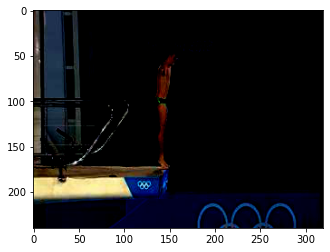

In [16]:
import matplotlib.pyplot as plt

plt.imshow(np.transpose(imgs[:,100,:,:], (1,2,0)))

## Create DataLoaders

In [17]:
from torch.utils.data import DataLoader

batch_size = 10
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                       shuffle=True, num_workers=0)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size,
                                      shuffle=False, num_workers=0)

In [18]:
for xb, yb in train_dl:
    print(xb.shape, yb.shape)
    break
for xb, yb in test_dl:
    print(xb.shape, yb.shape)
    break

torch.Size([10, 3, 151, 240, 320]) torch.Size([10])
torch.Size([10, 3, 151, 240, 320]) torch.Size([10])


## Define CNN Model

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(3,6,5)
        self.pool = nn.MaxPool3d(2,2)
        self.conv2 = nn.Conv3d(6,16,5)
        self.conv3 = nn.Conv3d(16,16,5)
        self.fc1 = nn.Linear(16*151*26*36, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))    # Conv1: H: (240-5+2*0)/1+1 = 236, W: (320-5+2*0)/1+1 = 316
        x = self.pool(x)             # Pool1: H: (236-2+2*0)/2+1= 118, W: (316-2+2*0)/2+1 = 158
        x = F.relu(self.conv2(x))    # Conv2: H: (118-5+2*0)/1+1 = 114, W: (158-5+2*0)/1+1 = 154
        x = self.pool(x)             # Pool2: H: (114-2+2*0)/2+1 = 57, W: (154-2+2*0)/2+1 = 77
        x = F.relu(self.conv3(x))    # Conv3: H: (57-5+2*0)/1+1 = 53, W: (77-5+2*0)/1+1 = 73
        x = self.pool(x)             # Pool3: H: (53-2+2*0)/2+1 = 26.5 W: (73-2+2*0)/2+1 = 36.5
        print(x.shape)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

## Define Loss Function & Optimizer

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Check GPU Availability

In [21]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
  
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
        
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 10.2
ID of current CUDA device: 0
Name of current CUDA device: GeForce GTX 1660 Ti


In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
net = net.to(device)

## Training

In [24]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_dl, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss= criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: CUDA out of memory. Tried to allocate 2.45 GiB (GPU 0; 6.00 GiB total capacity; 2.31 GiB already allocated; 2.26 GiB free; 2.31 GiB reserved in total by PyTorch)

In [34]:
import matplotlib.pylab as plt
def plot_loss(loss_hist, metric_hist):

    num_epochs= len(loss_hist["train"])

    plt.title("Train-Val Loss")
    plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
    plt.ylabel("Loss")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

    plt.title("Train-Val Accuracy")
    plt.plot(range(1,num_epochs+1), metric_hist["train"],label="train")
    plt.plot(range(1,num_epochs+1), metric_hist["val"],label="val")
    plt.ylabel("Accuracy")
    plt.xlabel("Training Epochs")
    plt.legend()
    plt.show()

## Output

### mynet_0808_2.txt

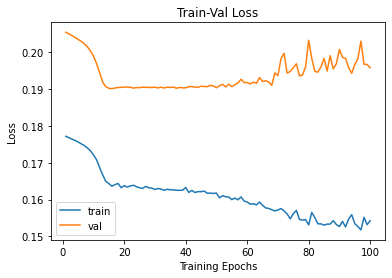

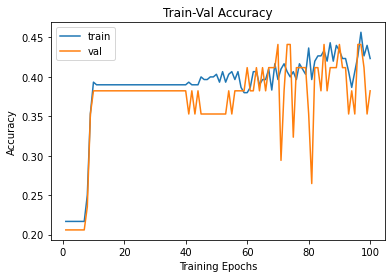

In [39]:
Loss_Histogram = {
    'train': [
        0.17718730409940084, 0.17681083122889202, 0.17643940965334573, 0.1760738984743754, 0.17565309643745422, 
        0.1751596470673879, 0.17468635400136312, 0.17406091968218484, 0.17326930920282999, 0.17217038909594218, 
        0.17083176294962565, 0.16873085975646973, 0.1667249631881714, 0.16496607422828674, 0.16436678846677144, 
        0.1636502214272817, 0.16405973652998607, 0.16439710736274718, 0.16323075493176778, 0.1638082448641459, 
        0.16339618762334188, 0.163719451824824, 0.16389079809188842, 0.16349862535794576, 0.16320321202278137, 
        0.16305421352386473, 0.16358233531316121, 0.1632181187470754, 0.1631208872795105, 0.16273179372151692, 
        0.16303155541419984, 0.16286568959554037, 0.16252199212710064, 0.16280856847763062, 0.1626641313234965, 
        0.16266014417012534, 0.16252906739711762, 0.16252202153205872, 0.16256643493970235, 0.16328637142976124, 
        0.16194921096165976, 0.16250391165415445, 0.16192769328753154, 0.16217335561911264, 0.16215834021568298, 
        0.16232495983441672, 0.16173186798890432, 0.1617623261610667, 0.1616708997885386, 0.16176769971847535, 
        0.16047889729340872, 0.1610681891441345, 0.16076121230920157, 0.1606962239742279, 0.15999594887097676, 
        0.16041143814722697, 0.15994273702303569, 0.16073703785737356, 0.15961154758930207, 0.15935174504915872, 
        0.15876163363456727, 0.158899365067482, 0.1585630238056183, 0.15932072043418885, 0.1584675564368566, 
        0.1577521526813507, 0.15759960432847342, 0.15725361744562785, 0.15693077067534128, 0.1571933990716934, 
        0.1575611388683319, 0.1569515025615692, 0.15611236671606699, 0.1547817208369573, 0.15615950604279835, 
        0.15707048376401264, 0.15462222437063852, 0.15443983614444734, 0.15456263462702433, 0.15314487318197886, 
        0.15652706225713095, 0.15512707432111103, 0.15342734456062318, 0.15341679553190868, 0.15306440929571788, 
        0.15334055602550506, 0.15335991621017456, 0.15427764932314555, 0.15323118289311727, 0.15267239292462667, 
        0.15409167230129242, 0.15258759001890818, 0.1546984084447225, 0.1559132679303487, 0.15347348392009735, 
        0.15268836160500845, 0.1517717738946279, 0.1552000669638316, 0.15320309241612753, 0.15426113426685334
    ], 
    'val': [
        0.20544753705754, 0.20499318838119507, 0.20454302254845114, 0.20403844118118286, 0.20349845816107356, 
        0.20298658048405366, 0.2023451188031365, 0.2015223643359016, 0.20039337522843303, 0.1989394601653604, 
        0.19697972956825704, 0.19446443108951345, 0.19189121092067046, 0.19069796099382288, 0.19021720395368688, 
        0.19013917796752033, 0.1902935539974886, 0.1904460261849796, 0.190478454617893, 0.19054973826688879, 
        0.19057214260101318, 0.19050406708436854, 0.19028290580300725, 0.1904320015626795, 0.1903944401180043, 
        0.19053776474560008, 0.1904959573465235, 0.19046085371690638, 0.19045087519813986, 0.19051752721562104, 
        0.19034445636412678, 0.19052942009533153, 0.19031177899416754, 0.19053237578448126, 0.1904552088064306, 
        0.1905610491247738, 0.19023416673435883, 0.19047720642650828, 0.1903478327919455, 0.19035273089128382, 
        0.19067273771061616, 0.19066813412834616, 0.19056322294123032, 0.1904977560043335, 0.1907885179800146, 
        0.1907300317988676, 0.1906581205480239, 0.1910114744130303, 0.19086785176221063, 0.19037912172429702, 
        0.1909313903135412, 0.19129399692311005, 0.19059136334587545, 0.1913476586341858, 0.19065460387398214, 
        0.19120938637677362, 0.19164360621396234, 0.19269244811114142, 0.19177559544058406, 0.19180061536676743, 
        0.19141814638586604, 0.19190926411572626, 0.1915726626620573, 0.19313918842988856, 0.19204860224443324, 
        0.1922638451351839, 0.19198182751150691, 0.19101080824347103, 0.1944175923571867, 0.19367949051015518, 
        0.1982988680110258, 0.1997203230857849, 0.19434625260970173, 0.1948019406374763, 0.19582046130124262, 
        0.19687401196535895, 0.19361012472825892, 0.19383266042260563, 0.19606131315231323, 0.20326659959905288, 
        0.19837831749635584, 0.19481057980481317, 0.19460062419666962, 0.19603953992619233, 0.19834979141459746, 
        0.19491958267548504, 0.19907654032987707, 0.19548974317662857, 0.19690798310672536, 0.20076810261782477, 
        0.19863448774113374, 0.19835526802960565, 0.19583566048566034, 0.19429644416360295, 0.19667498855029836, 
        0.1982175777940189, 0.20303815953871784, 0.19674441744299495, 0.1967076028094572, 0.19581812620162964
    ]
}
Metric_Histogram = {
    'train': [
        0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 0.21666666666666667, 
        0.21666666666666667, 0.21666666666666667, 0.25, 0.35333333333333333, 0.3933333333333333, 
        0.39, 0.39, 0.39, 0.39, 0.39, 
        0.39, 0.39, 0.39, 0.39, 0.39, 
        0.39, 0.39, 0.39, 0.39, 0.39, 
        0.39, 0.39, 0.39, 0.39, 0.39, 
        0.39, 0.39, 0.39, 0.39, 0.39, 
        0.39, 0.39, 0.39, 0.39, 0.39, 
        0.3933333333333333, 0.39, 0.39, 0.39, 0.4, 
        0.39666666666666667, 0.39666666666666667, 0.4, 0.4, 0.4033333333333333, 
        0.3933333333333333, 0.4066666666666667, 0.3933333333333333, 0.4033333333333333, 0.4066666666666667, 
        0.39666666666666667, 0.4066666666666667, 0.38666666666666666, 0.38, 0.38, 
        0.38666666666666666, 0.4066666666666667, 0.4066666666666667, 0.39, 0.39666666666666667, 
        0.39666666666666667, 0.41, 0.38333333333333336, 0.4166666666666667, 0.39666666666666667, 
        0.41, 0.4166666666666667, 0.4066666666666667, 0.4, 0.4066666666666667, 
        0.39666666666666667, 0.4166666666666667, 0.41, 0.4033333333333333, 0.43666666666666665, 
        0.39666666666666667, 0.42, 0.4266666666666667, 0.4266666666666667, 0.43333333333333335, 
        0.42, 0.44333333333333336, 0.42, 0.44, 0.43333333333333335, 
        0.42333333333333334, 0.42333333333333334, 0.4066666666666667, 0.38666666666666666, 0.4066666666666667, 
        0.4266666666666667, 0.45666666666666667, 0.4266666666666667, 0.44, 0.42333333333333334], 
    'val': [
        0.20588235294117646, 0.20588235294117646, 0.20588235294117646, 0.20588235294117646, 0.20588235294117646, 
        0.20588235294117646, 0.20588235294117646, 0.23529411764705882, 0.35294117647058826, 0.38235294117647056, 
        0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 
        0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 
        0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 
        0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 
        0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 
        0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 
        0.35294117647058826, 0.38235294117647056, 0.35294117647058826, 0.38235294117647056, 0.35294117647058826, 
        0.35294117647058826, 0.35294117647058826, 0.35294117647058826, 0.35294117647058826, 0.35294117647058826, 
        0.35294117647058826, 0.35294117647058826, 0.35294117647058826, 0.38235294117647056, 0.35294117647058826, 
        0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.38235294117647056, 0.4117647058823529, 
        0.38235294117647056, 0.38235294117647056, 0.4117647058823529, 0.38235294117647056, 0.4117647058823529, 
        0.38235294117647056, 0.4117647058823529, 0.4117647058823529, 0.4117647058823529, 0.4411764705882353, 
        0.29411764705882354, 0.38235294117647056, 0.4411764705882353, 0.4411764705882353, 0.3235294117647059, 
        0.4117647058823529, 0.4117647058823529, 0.4117647058823529, 0.4117647058823529, 0.35294117647058826, 
        0.2647058823529412, 0.4117647058823529, 0.4117647058823529, 0.38235294117647056, 0.4411764705882353, 
        0.38235294117647056, 0.4117647058823529, 0.4117647058823529, 0.4117647058823529, 0.4411764705882353, 
        0.4117647058823529, 0.4117647058823529, 0.35294117647058826, 0.38235294117647056, 0.35294117647058826, 
        0.4411764705882353, 0.4411764705882353, 0.4117647058823529, 0.35294117647058826, 0.38235294117647056
    ]
}
plot_loss(Loss_Histogram, Metric_Histogram)

### rnn_0807_2.txt

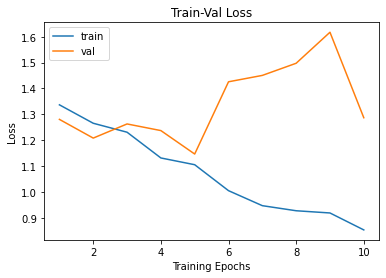

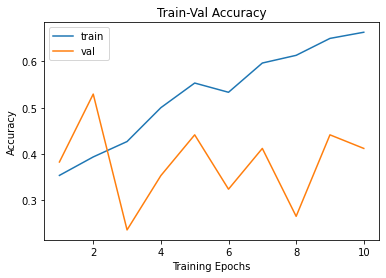

In [38]:
Loss_Histogram =  {
    'train': [
        1.3367832231521606, 1.265516105890274, 1.23089626789093, 1.1313225980599722, 1.1052244226137797, 
        1.0048987762133281, 0.9468625807762145, 0.9272213910023371, 0.9186433873573939, 0.8531159998973211], 
    'val': [
        1.2805001946056591, 1.2081668692476608, 1.2628381532781265, 1.2371984895537882, 1.1465108920546139, 
        1.4258564605432398, 1.45053210328607, 1.4974896925337173, 1.617427573484533, 1.286914331071517]}
Metric_Histogram =  {
    'train': [
        0.35333333333333333, 0.3933333333333333, 0.4266666666666667, 0.5, 0.5533333333333333, 
        0.5333333333333333, 0.5966666666666667, 0.6133333333333333, 0.65, 0.6633333333333333], 
    'val': [
        0.38235294117647056, 0.5294117647058824, 0.23529411764705882, 0.35294117647058826, 0.4411764705882353, 
        0.3235294117647059, 0.4117647058823529, 0.2647058823529412, 0.4411764705882353, 0.4117647058823529]}
plot_loss(Loss_Histogram, Metric_Histogram)

### rnn_0809_1.txt

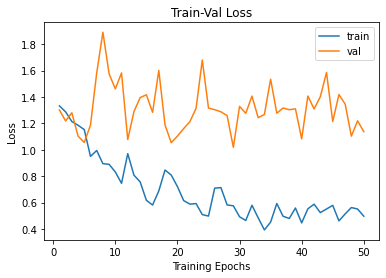

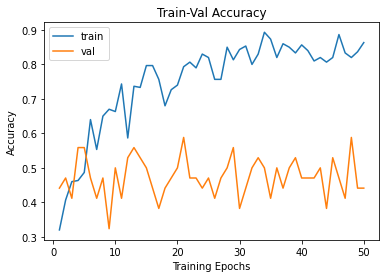

In [40]:
Loss_Histogram =  {
    'train': [
        1.3321648208300272, 1.2868022076288859, 1.213755828142166, 1.1853086566925048, 1.1527899154027303, 
        0.9498439832528432, 0.9944529455900192, 0.8945920997858048, 0.8898206971089045, 0.8317751367886861, 
        0.745932098031044, 0.9704820873339971, 0.8077129246791204, 0.7565676273902258, 0.6172278579076131, 
        0.5813339279095332, 0.6887574017047882, 0.8466719977060954, 0.8087467126051585, 0.7211554173628489, 
        0.615313752690951, 0.588383091489474, 0.5925574791431427, 0.509149843454361, 0.4980303212006887, 
        0.7094593099753062, 0.713568163116773, 0.5821542070309321, 0.5756931910912196, 0.4926404831806819, 
        0.4645927047729492, 0.5798231422901153, 0.4845072066783905, 0.3931293467680613, 0.4523421879609426, 
        0.5932147816816966, 0.4967959002653758, 0.47980467200279237, 0.5589738384882609, 0.4462188212076823, 
        0.5529775591691335, 0.5878635450204214, 0.524273593823115, 0.5513984350363413, 0.5790892501672109, 
        0.46156629343827565, 0.5141615231831869, 0.5624564814567566, 0.551433801651001, 0.49709599137306215], 
    'val': [
        1.3014188864651848, 1.2180777192115784, 1.279851289356456, 1.1036520775626688, 1.0552997589111328, 
        1.1861530332004322, 1.5808458398370182, 1.8897678220973295, 1.5750925365616293, 1.4608823937528275, 
        1.5815229415893555, 1.0774952629033256, 1.289006373461555, 1.395035866428824, 1.4163897037506104, 
        1.2831363870817072, 1.6008157344425427, 1.1882383753271664, 1.0534669581581564, 1.1034494112519657, 
        1.1601509802481706, 1.2124948150971357, 1.313732872991001, 1.6794110711883097, 1.315345857073279, 
        1.303362506277421, 1.2874277795062345, 1.2583369191955118, 1.01889929876608, 1.328380097361172, 
        1.2759408249574549, 1.4062242437811459, 1.2430126526776482, 1.2673981645528007, 1.5343137839261223, 
        1.2764237452955807, 1.3159558632794548, 1.3032306432724, 1.3097994888530058, 1.0824127547881182, 
        1.4067143201828003, 1.3090299262719995, 1.401308783713509, 1.5848565347054426, 1.2140519724172705, 
        1.4181895606658037, 1.3462835234754227, 1.1031399649732254, 1.2190744911923128, 1.13689203823314
    ]
}
Metric_Histogram =  {
    'train': [
        0.32, 0.4066666666666667, 0.46, 0.4633333333333333, 0.4866666666666667, 
        0.64, 0.5533333333333333, 0.65, 0.67, 0.6633333333333333, 
        0.7433333333333333, 0.5866666666666667, 0.7366666666666667, 0.7333333333333333, 0.7966666666666666, 
        0.7966666666666666, 0.7566666666666667, 0.68, 0.7266666666666667, 0.74, 
        0.7933333333333333, 0.8066666666666666, 0.79, 0.83, 0.82, 
        0.7566666666666667, 0.7566666666666667, 0.85, 0.8133333333333334, 0.8433333333333334, 
        0.8533333333333334, 0.8, 0.83, 0.8933333333333333, 0.8733333333333333, 
        0.82, 0.86, 0.85, 0.8333333333333334, 0.8566666666666667, 
        0.84, 0.81, 0.82, 0.8066666666666666, 0.82, 
        0.8866666666666667, 0.8333333333333334, 0.82, 0.8366666666666667, 0.8633333333333333], 
    'val': [
        0.4411764705882353, 0.47058823529411764, 0.4117647058823529, 0.5588235294117647, 0.5588235294117647, 
        0.47058823529411764, 0.4117647058823529, 0.47058823529411764, 0.3235294117647059, 0.5, 
        0.4117647058823529, 0.5294117647058824, 0.5588235294117647, 0.5294117647058824, 0.5, 
        0.4411764705882353, 0.38235294117647056, 0.4411764705882353, 0.47058823529411764, 0.5, 
        0.5882352941176471, 0.47058823529411764, 0.47058823529411764, 0.4411764705882353, 0.47058823529411764, 
        0.4117647058823529, 0.47058823529411764, 0.5, 0.5588235294117647, 0.38235294117647056, 
        0.4411764705882353, 0.5, 0.5294117647058824, 0.5, 0.4117647058823529, 
        0.5, 0.4411764705882353, 0.5, 0.5294117647058824, 0.47058823529411764, 
        0.47058823529411764, 0.47058823529411764, 0.5, 0.38235294117647056, 0.5294117647058824, 
        0.47058823529411764, 0.4117647058823529, 0.5882352941176471, 0.4411764705882353, 0.4411764705882353
    ]
}
plot_loss(Loss_Histogram, Metric_Histogram)